In [1]:
import os
import glob
from PIL import Image
import numpy as np
import torch
import torchvision
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

## 1. Load the Dataset in PyTorch


#### 1.1 Define the Dataset Class


In [2]:
class DIV2kDataset(Dataset):
    def __init__(self, hr_dir, lr_dir, transform_lr=None, transform_hr=None):
        self.hr_dir = hr_dir
        self.lr_dir = lr_dir
        self.hr_images = sorted(glob.glob(os.path.join(hr_dir, '*.png')))
        self.lr_images = sorted(glob.glob(os.path.join(lr_dir, '*.png')))
        self.transform_lr = transform_lr
        self.transform_hr = transform_hr

        # Debugging: Print the number of images found
        print(f'Found {len(self.hr_images)} HR images in {hr_dir}')
        print(f'Found {len(self.lr_images)} LR images in {lr_dir}')

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, index):
        hr_image = Image.open(self.hr_images[index])
        lr_image = Image.open(self.lr_images[index])

        if self.transform_lr:
            lr_image = self.transform_lr(lr_image)
        if self.transform_hr:
            hr_image = self.transform_hr(hr_image)

        return lr_image, hr_image

#### 1.2 Define transformations


In [3]:
transformations_lr = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
transformations_hr = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

#### 1.3 Initialize the Dataset and DataLoader


In [4]:
hr_train_dir = '/home/tanmaypatil/Documents/DS/DL/SRGAN/dataset/DIV2K_train_HR'
lr_train_dir = '/home/tanmaypatil/Documents/DS/DL/SRGAN/dataset/DIV2K_train_LR_x8'
hr_val_dir = '/home/tanmaypatil/Documents/DS/DL/SRGAN/dataset/DIV2K_valid_HR'
lr_val_dir = '/home/tanmaypatil/Documents/DS/DL/SRGAN/dataset/DIV2K_valid_LR_x8'

train_dataset = DIV2kDataset(hr_train_dir, lr_train_dir,
                             transform_lr=transformations_lr, transform_hr=transformations_hr)
valid_dataset = DIV2kDataset(
    hr_val_dir, lr_val_dir, transform_lr=transformations_lr, transform_hr=transformations_hr)

train_loader = DataLoader(train_dataset, batch_size=16,
                          shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1,
                          shuffle=False, num_workers=4)

Found 800 HR images in /home/tanmaypatil/Documents/DS/DL/SRGAN/dataset/DIV2K_train_HR
Found 800 LR images in /home/tanmaypatil/Documents/DS/DL/SRGAN/dataset/DIV2K_train_LR_x8
Found 100 HR images in /home/tanmaypatil/Documents/DS/DL/SRGAN/dataset/DIV2K_valid_HR
Found 100 LR images in /home/tanmaypatil/Documents/DS/DL/SRGAN/dataset/DIV2K_valid_LR_x8


## 2. Implementing Generator Network


#### 2.1 Residual Block


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(
            channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.prelu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return out

#### 2.2 UpScaling Block


In [6]:
class UpscalingBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super(UpscalingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels *
                              scale_factor ** 2, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        out = self.conv(x)
        out = self.pixel_shuffle(out)
        out = self.prelu(out)
        return out

#### 2.3 Generator


In [7]:
import configparser

config = configparser.ConfigParser()
config.read('/home/tanmaypatil/Documents/DS/DL/SRGAN/config.ini')
gen_config = config['generator']
dis_config = config['discriminator']
dataset_config = config['dataset']


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        input_channels = int(gen_config['input_channels'])
        number_of_residuals = int(
            gen_config['number_of_residual_blocks'])
        number_of_channels = int(gen_config['number_of_channels'])
        upscale_factor = int(gen_config['upscale_factor'])
        kernel_size1 = int(gen_config['kernel_size1'])
        kernel_size2 = int(gen_config['kernel_size2'])
        padding1 = int(gen_config['padding1'])
        padding2 = int(gen_config['padding2'])

        self.conv1 = nn.Conv2d(
            input_channels, number_of_channels, kernel_size=kernel_size1, stride=1, padding=padding1)
        self.prelu = nn.PReLU()

        self.residuals = nn.Sequential(
            *[ResidualBlock(number_of_channels) for _ in range(number_of_residuals)])

        self.conv2 = nn.Conv2d(number_of_channels, number_of_channels, kernel_size=kernel_size2,
                               stride=1, padding=padding2, bias=False)
        self.bn2 = nn.BatchNorm2d(number_of_channels)

        self.upscale = nn.Sequential(
            *[UpscalingBlock(number_of_channels, upscale_factor) for _ in range(upscale_factor // 2)])

        self.conv3 = nn.Conv2d(number_of_channels, 3,
                               kernel_size=kernel_size1, stride=1, padding=padding1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu(x)

        residual = x
        x = self.residuals(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += residual

        x = self.upscale(x)
        x = self.conv3(x)
        return x

In [8]:
import os
os.path.join(os.path.abspath(os.path.curdir), 'src')

'/home/tanmaypatil/Documents/DS/DL/SRGAN/src'

## 3. Discriminator


In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # dis_config = dis_config
        input_channels = int(dis_config['input_channels'])
        input_size = int(dis_config['input_size'])
        fc_size = int(dis_config['fc_size'])
        leaky_relu_slope = float(dis_config['leaky_relu_slope'])

        def discriminator_block(in_filters, out_filters, stride):
            return nn.Sequential(
                nn.Conv2d(in_filters, out_filters, kernel_size=3,
                          stride=stride, padding=1),
                nn.BatchNorm2d(out_filters),
                nn.LeakyReLU(leaky_relu_slope, inplace=True)
            )

        self.model = nn.Sequential(
            *discriminator_block(input_channels, 32, stride=1),
            *discriminator_block(32, 64, stride=4),
            *discriminator_block(64, 128, stride=4),
        )

        # Calculate the size after convolutions
        conv_output_size = input_size // 16  # Downscaled twice by stride=4

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(128 * conv_output_size * conv_output_size, fc_size),
            nn.LeakyReLU(leaky_relu_slope, inplace=True),
            nn.Linear(fc_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## 4. Loss Functions


#### 4.1 Adversarial Loss


In [11]:
adversarial_loss = nn.BCELoss()

#### 4.2 Content Loss


In [12]:
class VGGFeatureExtractor(nn.Module):
    def __init__(self, feature_layer=15, use_cuda=True):
        super(VGGFeatureExtractor, self).__init__()
        vgg19 = torchvision.models.vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(
            *list(vgg19.features.children())[:feature_layer])
        if use_cuda:
            self.feature_extractor = self.feature_extractor.cuda()

    def forward(self, img):
        return self.feature_extractor(img)


content_loss = nn.MSELoss()

In [13]:
# Initialize generator and discriminator
generator = Generator().cuda()
discriminator = Discriminator().cuda()

# Initialize feature extractor
feature_extractor = VGGFeatureExtractor().cuda()

/home/tanmaypatil/Documents/DS/DL/SRGAN/.venv/lib64/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tanmaypatil/Documents/DS/DL/SRGAN/.venv/lib64/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=9e-5)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

# Pretraining the Generator


In [15]:
from colorama import Fore, Style
import sys


def print_progress(epoch, num_epochs, batch, num_batches, loss, bar_length=30):
    progress = (batch + 1) / num_batches
    progress_bar = int(progress * bar_length)

    sys.stdout.write(
        f"{Fore.CYAN}{Style.BRIGHT}Epoch [{epoch}/{num_epochs}] |")
    sys.stdout.write(f"{Fore.YELLOW}{
                     '█' * progress_bar}{Fore.WHITE}{'-' * (bar_length - progress_bar)}")
    sys.stdout.write(f"| {Fore.GREEN}{int(progress * 100)}% {Style.RESET_ALL}")
    sys.stdout.write(
        f" [Batch {batch + 1}/{num_batches}] [Loss: {Fore.RED}{loss:.4f}{Style.RESET_ALL}]\r")
    sys.stdout.flush()

In [16]:
losses = []
criterion = torch.nn.MSELoss()  # You can also use nn.L1Loss() if you prefer

optimizer_pre_G = torch.optim.Adam(generator.parameters(), lr=1e-6)
num_pretrain_epochs = 15  # Adjust the number of epochs based on your needs

for epoch in range(num_pretrain_epochs):
    for i, (imgs_lr, imgs_hr) in enumerate(train_loader):
        try:
            imgs_lr = imgs_lr.cuda()
            imgs_hr = imgs_hr.cuda()

            optimizer_pre_G.zero_grad()

            # Generate high-resolution images from low-resolution input
            gen_hr = generator(imgs_lr)

            # Calculate pixel-wise loss against the high-resolution ground truth
            loss = criterion(gen_hr, imgs_hr)
            losses.append(loss.item())
            loss.backward()
            optimizer_G.step()

            print_progress(epoch, num_pretrain_epochs, i,
                           len(train_loader), loss.item())

        except RuntimeError as e:
            print(f"Error in batch {i}: {e}")
            break

    # Optionally save generated images after each epoch
    save_image(
        gen_hr.data, f'images/pre_train/pretrain_gen_hr_epoch_{epoch}.png', normalize=True)
# Assuming your pretrained generator is stored in a variable called 'generator'
torch.save(generator.state_dict(), 'pretrained_generator.pth')

In [17]:
length = len(train_loader)
epoch_wise = []

for i in range(0, 751, 50):
    if i != 0:
        epoch_wise.append(losses[i-1])
    else:
        epoch_wise.append(losses[i])

NameError: name 'losses' is not defined

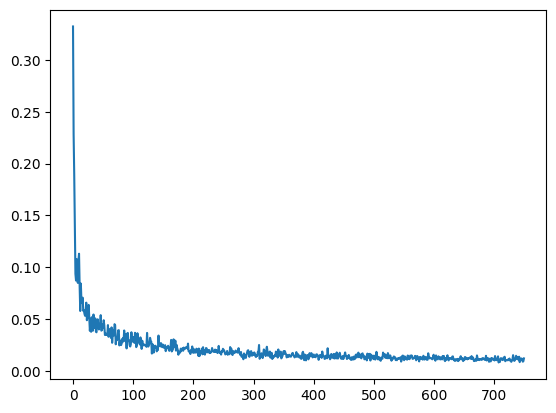

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

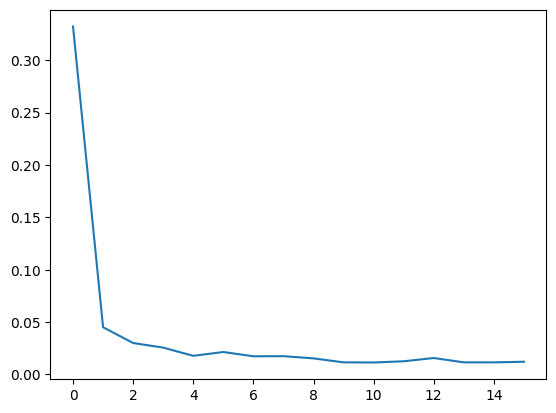

In [ ]:
plt.plot(epoch_wise)
plt.show()

# Adversarial training


In [18]:
gen_losses = []
dis_losses = []
real_losses = []
fake_losses = []
g_losses = []
content_losses = []
epoch_wise_g_losses = []
epoch_wise_d_losses = []

In [19]:
d_steps = 1  # Number of discriminator updates per generator update
g_steps = 5
num_epochs = 75
# Directory to save generated images
os.makedirs('images', exist_ok=True)
os.makedirs('images/pre_train', exist_ok=True)

for epoch in range(num_epochs):
    for i, (imgs_lr, imgs_hr) in enumerate(train_loader):
        try:
            imgs_lr = imgs_lr.cuda()
            imgs_hr = imgs_hr.cuda()

            for _ in range(d_steps):
                optimizer_D.zero_grad()
                gen_hr = generator(imgs_lr)
                valid = torch.ones((imgs_lr.size(0), 1),
                                   requires_grad=False).cuda() * 0.9
                fake = torch.zeros((imgs_lr.size(0), 1),
                                   requires_grad=False).cuda() * 0.1
                real_loss = adversarial_loss(discriminator(imgs_hr), valid)
                fake_loss = adversarial_loss(
                    discriminator(gen_hr.detach()), fake)
                d_loss = (real_loss + fake_loss) / 2

                real_losses.append(real_loss.item())
                fake_losses.append(fake_loss.item())
                dis_losses.append(d_loss.item())

                d_loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    discriminator.parameters(), max_norm=1.0)
                optimizer_D.step()

            for index in range(g_steps):
                optimizer_G.zero_grad()
                gen_hr = generator(imgs_lr)
                valid = torch.ones((imgs_lr.size(0), 1),
                                   requires_grad=False).cuda() * 0.9
                g_loss = adversarial_loss(discriminator(gen_hr), valid)
                gen_features = feature_extractor(gen_hr)
                real_features = feature_extractor(imgs_hr)
                content_loss_value = content_loss(gen_features, real_features)
                g_total_loss = g_loss + content_loss_value
                if index % g_steps == 0:
                    g_losses.append(g_loss.item())
                    content_losses.append(content_loss_value.item())
                    gen_losses.append(g_total_loss.item())

                g_total_loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    generator.parameters(), max_norm=1.0)
                optimizer_G.step()

                print_progress(epoch, num_epochs, i,
                               length, str(f'G: {g_total_loss.item()}, D: {d_loss.item()}'))

            epoch_wise_g_losses.append(g_total_loss.item())
            epoch_wise_d_losses.append(d_loss.item())

            # Save generated images at regular intervals
            # if i % 10 == 0:

        except RuntimeError as e:
            print(f"Error in batch {i}: {e}")
            break
    save_image(gen_hr.data, f'images/gen_hr_epoch_{epoch}.png', normalize=True)

Epoch [0/75] |------------------------------| 2% 

ValueError: Unknown format code 'f' for object of type 'str'

In [ ]:
model_scripted = torch.jit.script(generator)
model_scripted.save('models/torch_scriptsmodel_scripted_vgg15_xl.pt')

In [ ]:
torch.save(generator.state_dict(), 'generator_vgg15_xl_state.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

In [ ]:
torch.save(generator, 'generator_vgg15_xl_model.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

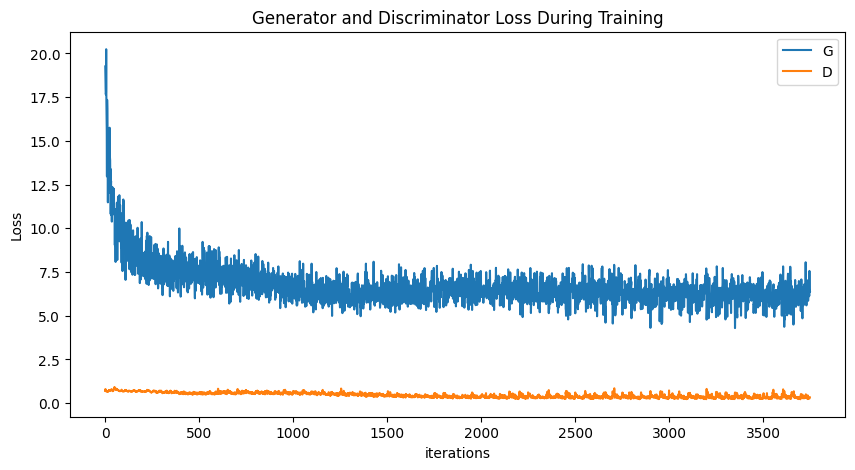

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses, label="G")
plt.plot(dis_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

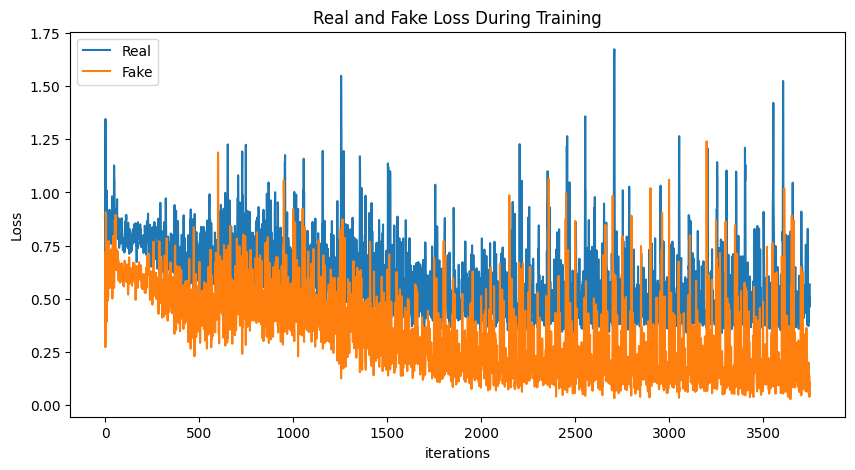

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Real and Fake Loss During Training")
plt.plot(real_losses, label="Real")
plt.plot(fake_losses, label="Fake")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

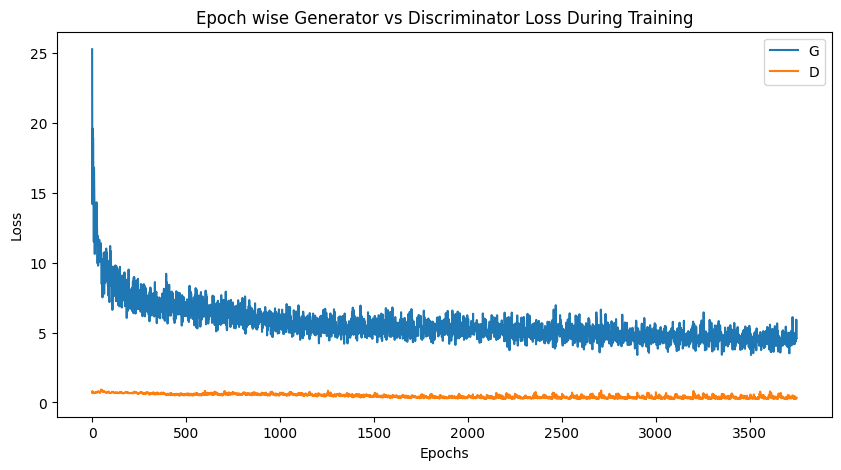

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Epoch wise Generator vs Discriminator Loss During Training")
plt.plot(epoch_wise_g_losses, label="G")
plt.plot(epoch_wise_d_losses, label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import gc


gc.collect()
torch.cuda.empty_cache()

In [ ]:
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image
import torch
import time

st = time.time()
# Load and preprocess the low-resolution image
lr_image = Image.open('dataset/DIV2K_valid_LR_x8/0885x8.png')
preprocess = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
lr_tensor = preprocess(lr_image).unsqueeze(
    0).cuda()  # Add batch dimension and move to GPU

# Set the model to evaluation mode
generator.eval()

# Generate the high-resolution image
with torch.no_grad():
    hr_tensor = generator(lr_tensor)

# Save the generated high-resolution image
save_image(lr_tensor.data, 'gen_lr_test_15.png', normalize=True)
save_image(hr_tensor.data, 'gen_hr_test_15.png', normalize=True)
print(time.time() - st)

0.020737171173095703
